In [2]:
import numpy as np
import matplotlib.pylab as plt
import sklearn
from skimage import io
import tensorflow as tf
%matplotlib inline

from load_animals import *
from influence.iter_attack import get_projection_to_box_around_orig_point
from influence.inceptionModel import BinaryInceptionModel
from data_poisoning import data_poisoning

from Experiment_1 import dataset_metadatas, experiment_result_metadata_to_FN, FN_to_experiment_result_metadata

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def analyze_results(indices_and_poisons_FNs, visualize=False, tsne=False, logits=False):
    # Get metadata from file name
    FN_1, FN_2 = indices_and_poisons_FNs
    first_is_indices = FN_to_experiment_result_metadata(FN_1)["contents_type"] == "indices"
    if first_is_indices:
        indices_FN = FN_1
        poisons_FN = FN_2
    else:
        indices_FN = FN_2
        poisons_FN = FN_1
    
    # Get dataset metadata and load dataset
    dataset_name = FN_to_experiment_result_metadata(indices_FN)["dataset_name"]
    dataset_metadata = dataset_metadatas[dataset_name]
    
    # Constants that don't change for Inception (May need to change for other feature extraction methods like Resnet)
    img_side = 299
    num_channels = 3
    batch_size = 100
    initial_learning_rate = 0.001 
    keep_probs = None
    decay_epochs = [1000, 10000]
    weight_decay = 0.001
    
    # Variables used throughout the analysis
    training_dataset_classes = dataset_metadata["classes"]
    num_train_ex_per_class = dataset_metadata["num_train_ex_per_class"]
    num_test_ex_per_class = dataset_metadata["num_test_ex_per_class"]
    num_classes = len(training_dataset_classes)
    num_training_points = num_train_ex_per_class * num_classes
    num_testing_points = num_test_ex_per_class * num_classes
    poisoned_training_points = np.load(poisons_FN)
    poisoned_training_points_indices = np.load(indices_FN)
    target_test_points_indices = [FN_to_experiment_result_metadata(indices_FN)["test_idx"]] # Currently the file name has one test index, need to extend to file names with multiple test indices
    num_target_test_points = len(target_test_points_indices)
    num_poisoned_training_points = len(poisoned_training_points_indices)
    method = FN_to_experiment_result_metadata(indices_FN)["method"]
    
    # load dataset
    def get_dataset(classes):
        classes_str = '_'.join(classes)
        dataset_name = '{}_{}_{}'.format(classes_str, num_train_ex_per_class, num_test_ex_per_class)
        # extract_and_rename_animals()
        data_sets = load_animals(num_train_ex_per_class=num_train_ex_per_class, 
                                 num_test_ex_per_class=num_test_ex_per_class,
                                 classes=classes)
        return data_sets
    data_sets = get_dataset(dataset_metadata["classes"])
    
    def render_img(img):
        img_copy = np.copy(img)
        img_copy /= 2
        img_copy += 0.5
        io.imshow(img_copy)
    
    if visualize:
        # render original training points and poisoned ones
        screen_width = 12.5
        plt.figure(figsize=(screen_width, screen_width/num_poisoned_training_points * 2))
        for i, index_to_poison in enumerate(poisoned_training_points_indices):
            plt.subplot(2,num_poisoned_training_points,i+1)
            plt.title("Original Training Image [{}]".format(index_to_poison))
            render_img(data_sets.train.x[index_to_poison].reshape((img_side,img_side,num_channels)))

        for i, (training_point, index_to_poison) in enumerate(zip(poisoned_training_points, poisoned_training_points_indices)):
            plt.subplot(2,num_poisoned_training_points,num_poisoned_training_points+i+1)
            plt.title("Poisoned Training Image [{}]".format(index_to_poison))
            render_img(training_point.reshape((img_side,img_side,num_channels)))

        # render target test images
        plt.figure(figsize=(screen_width,screen_width/num_target_test_points))
        for target_index in target_test_points_indices:
            plt.subplot(2,num_poisoned_training_points,i+1)
            plt.title("Target test image [{}]".format(target_index))
            render_img(data_sets.test.x[target_index].reshape((img_side,img_side,num_channels)))
        plt.show()
    
    if not tsne and not logits:
        return
    
    print("Setting up full model...")
    full_graph = tf.Graph()
    with full_graph.as_default():
        full_model_name = '%s_inception_wd-%s' % ('_'.join(training_dataset_classes), weight_decay)
        full_model = BinaryInceptionModel(
            img_side=img_side,
            num_channels=num_channels,
            weight_decay=weight_decay,
            num_classes=num_classes, 
            batch_size=batch_size,
            data_sets=data_sets,
            initial_learning_rate=initial_learning_rate,
            keep_probs=keep_probs,
            decay_epochs=decay_epochs,
            mini_batch=True,
            train_dir='output',
            log_dir='log',
            model_name=full_model_name)
    
    if tsne:
        all_dataset_x = np.concatenate([np.copy(data_sets.train.x), 
                                        poisoned_training_points, 
                                        poisoned_training_points_clipped if method == "FC" else [], 
                                        data_sets.test.x[target_test_points_indices]
                                       ], axis = 0)
        all_dataset_labels = np.concatenate([np.copy(data_sets.train.labels),  
                                             np.copy(data_sets.train.labels[poisoned_training_points_indices]), 
                                             np.copy(data_sets.train.labels[poisoned_training_points_indices]) if method == "FC" else [],
                                             data_sets.test.labels[target_test_points_indices]], axis = 0)
        all_dataset = DataSet(all_dataset_x, all_dataset_labels)
        print "Extracting latent space features..."
        with full_graph.as_default():
            all_inceptions = full_model.generate_inception_features(all_dataset, None)
    
        # Calculate tSNE
        from sklearn.manifold import TSNE
        print "Calculating tSNE..."
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=69)
        tsne_results = tsne.fit_transform(all_inceptions)

        plt.figure(figsize=(12,12))
        # plot entire training dataset
        for class_label in range(num_classes):
            class_mask = data_sets.train.labels == class_label
            plt.scatter(tsne_results.T[0][:num_training_points][class_mask], 
                        tsne_results.T[1][:num_training_points][class_mask], 
                        label=training_dataset_classes[class_label]) 

        # plot training points before poison
        plt.scatter(tsne_results.T[0][poisoned_training_points_indices], 
                    tsne_results.T[1][poisoned_training_points_indices], 
                    label="Original Training Points", marker='*', s=200)
        for index, coordinate in zip(poisoned_training_points_indices, tsne_results[poisoned_training_points_indices]):
            plt.annotate(s=str(index), xy = coordinate)
        # plot training points after poison no clipping
        plt.scatter(tsne_results.T[0][num_training_points:num_training_points+num_poisoned_training_points], 
                    tsne_results.T[1][num_training_points:num_training_points+num_poisoned_training_points], 
                    label="Non-rescaled poisoned training point", marker='*', s=200)
        for index, coordinate in zip(poisoned_training_points_indices, tsne_results[num_training_points:num_training_points+num_poisoned_training_points]):
            plt.annotate(s=str(index), xy = coordinate)
        # plot training points after poison with clipping (if applicable)
        if method == "FC":
            plt.scatter(tsne_results.T[0][-num_target_test_points-num_poisoned_training_points:-num_target_test_points], 
                        tsne_results.T[1][-num_target_test_points-num_poisoned_training_points:-num_target_test_points], 
                        label="Rescaled poisoned training point", marker='*', s=200)
            for index, coordinate in zip(poisoned_training_points_indices, tsne_results[-num_target_test_points-num_poisoned_training_points:-num_target_test_points]):
                plt.annotate(s=str(index), xy = coordinate)
        # plot target test points
        plt.scatter( tsne_results.T[0][-num_target_test_points:], tsne_results.T[1][-num_target_test_points:], label="Target test points", marker='*', s=200)
        for index, coordinate in zip(target_test_points_indices, tsne_results[-num_target_test_points:]):
            plt.annotate(s=str(index), xy = coordinate)

        plt.legend()
        plt.show()
    
    if logits:
        print "Training on clean dataset..."
        with full_graph.as_default():
            clean_w = full_model.retrain_and_get_weights(data_sets.train.x, data_sets.train.labels)

        clean_total_test_logits = full_model.get_preds(data_sets.test, np.arange(len(data_sets.test.x)))
        clean_total_test_acc = np.sum(np.argmax(clean_total_test_logits, axis=1) == data_sets.test.labels) / float(num_testing_points)
        clean_test_logits = full_model.get_preds(data_sets.test, target_test_points_indices) # target_test_img_indices should be a list

        poisoned_data_set_x = np.copy(data_sets.train.x)
        poisoned_data_set_x[imgs_to_poison] = poisoned_images
        poisoned_data_set_labels = np.copy(data_sets.train.labels)

        print "Training on poisoned dataset..."
        with full_graph.as_default():
            poisoned_w = full_model.retrain_and_get_weights(poisoned_data_set_x, poisoned_data_set_labels)

        poisoned_total_test_logits = full_model.get_preds(data_sets.test, np.arange(len(data_sets.test.x)))
        poisoned_total_test_acc = np.sum(np.argmax(poisoned_total_test_logits, axis=1) == data_sets.test.labels) / float(num_testing_points)
        poisoned_test_logits = full_model.get_preds(data_sets.test, target_test_points_indices) # target_test_img_indices should be a list

        return (clean_total_test_acc, poisoned_total_test_acc), (clean_test_logits, poisoned_test_logits)

In [16]:
file_names = !ls -tr Experiment_results/Experiment_1/
file_names[:14]

['Experiment_1_indices_IF_Dog-Fish_num_train_1__568.npy',
 'Experiment_1_poisons_IF_Dog-Fish_num_train_1__568.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_1__42.npy',
 'Experiment_1_poisons_IF_Dog-Fish_num_train_1__42.npy',
 'Experiment_1_poisons_IF_Dog-Fish_num_train_1__562.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_1__562.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_1__328.npy',
 'Experiment_1_poisons_IF_Dog-Fish_num_train_1__328.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_1__159.npy',
 'Experiment_1_poisons_IF_Dog-Fish_num_train_1__159.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_1__146.npy',
 'Experiment_1_poisons_IF_Dog-Fish_num_train_1__146.npy',
 'Experiment_1_indices_IF_Dog-Fish_num_train_1__71.npy',
 'Experiment_1_poisons_IF_Dog-Fish_num_train_1__71.npy']

In [17]:
source_dir = "Experiment_results/Experiment_1/"
indices_poisons_pairs = []
for i in range(0,14,2):
    indices_poisons_pairs.append((source_dir+file_names[i], source_dir+file_names[i+1]))
indices_poisons_pairs

[('Experiment_results/Experiment_1/Experiment_1_indices_IF_Dog-Fish_num_train_1__568.npy',
  'Experiment_results/Experiment_1/Experiment_1_poisons_IF_Dog-Fish_num_train_1__568.npy'),
 ('Experiment_results/Experiment_1/Experiment_1_indices_IF_Dog-Fish_num_train_1__42.npy',
  'Experiment_results/Experiment_1/Experiment_1_poisons_IF_Dog-Fish_num_train_1__42.npy'),
 ('Experiment_results/Experiment_1/Experiment_1_poisons_IF_Dog-Fish_num_train_1__562.npy',
  'Experiment_results/Experiment_1/Experiment_1_indices_IF_Dog-Fish_num_train_1__562.npy'),
 ('Experiment_results/Experiment_1/Experiment_1_indices_IF_Dog-Fish_num_train_1__328.npy',
  'Experiment_results/Experiment_1/Experiment_1_poisons_IF_Dog-Fish_num_train_1__328.npy'),
 ('Experiment_results/Experiment_1/Experiment_1_indices_IF_Dog-Fish_num_train_1__159.npy',
  'Experiment_results/Experiment_1/Experiment_1_poisons_IF_Dog-Fish_num_train_1__159.npy'),
 ('Experiment_results/Experiment_1/Experiment_1_indices_IF_Dog-Fish_num_train_1__146.np

Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz


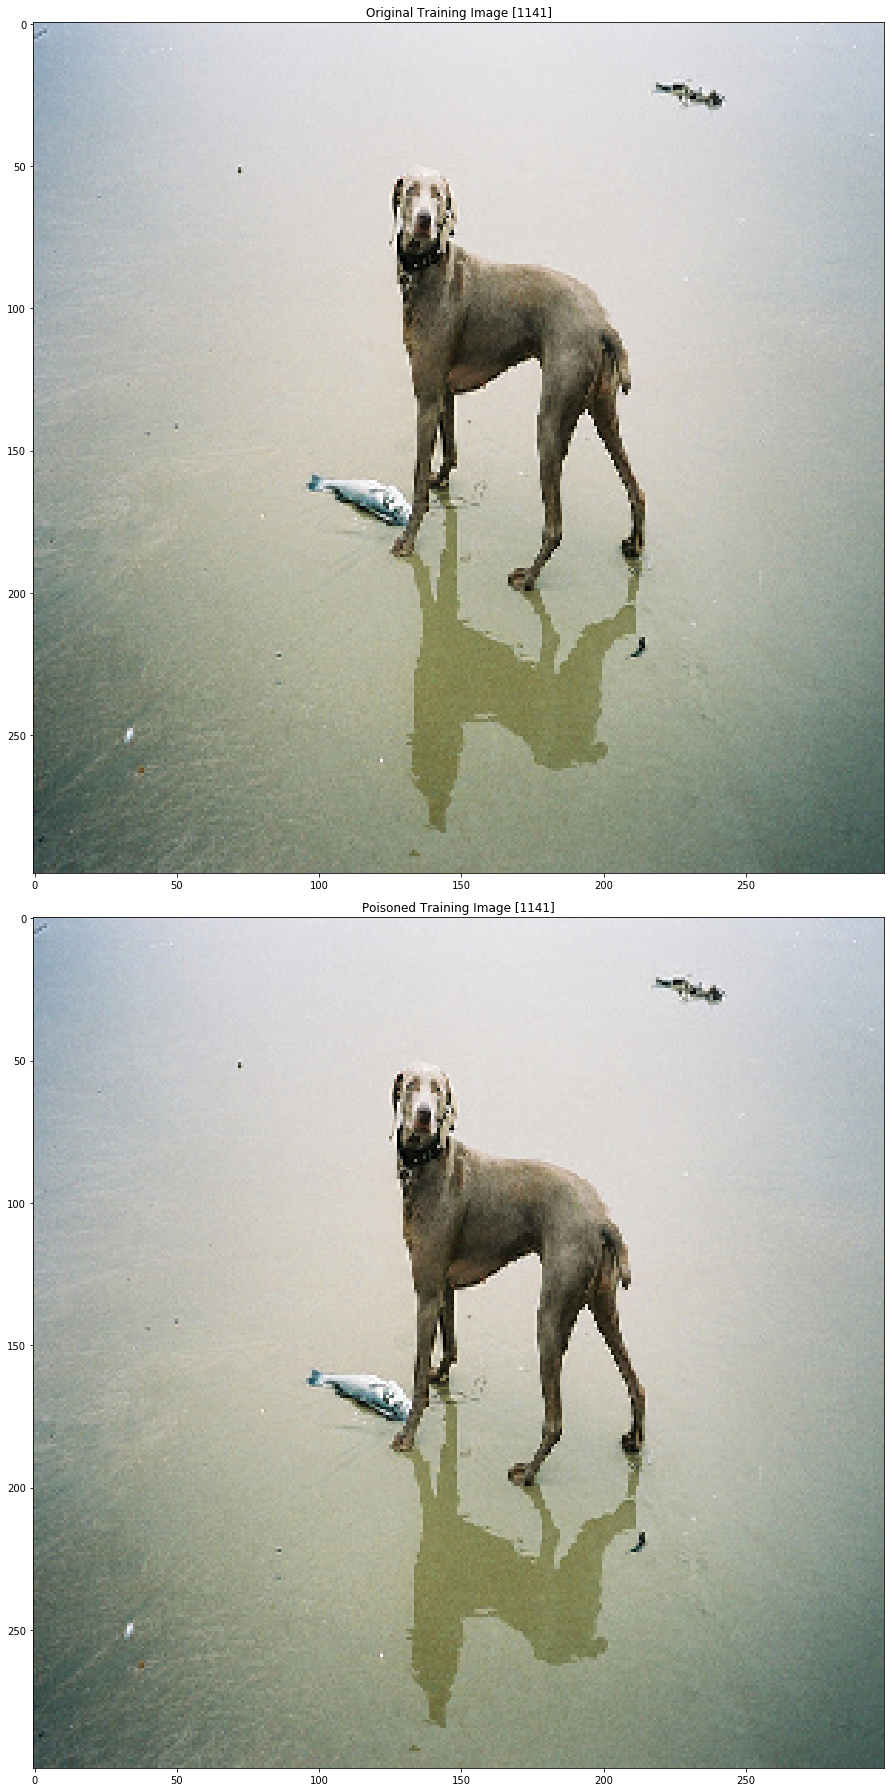

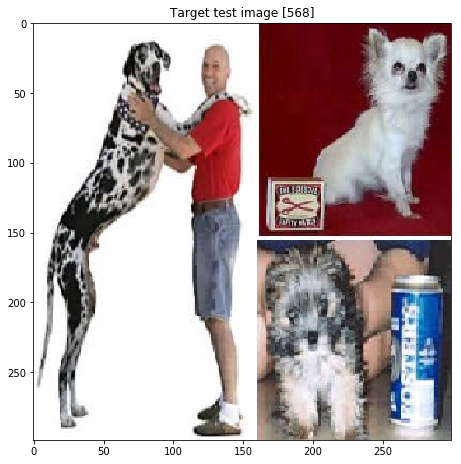

Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz


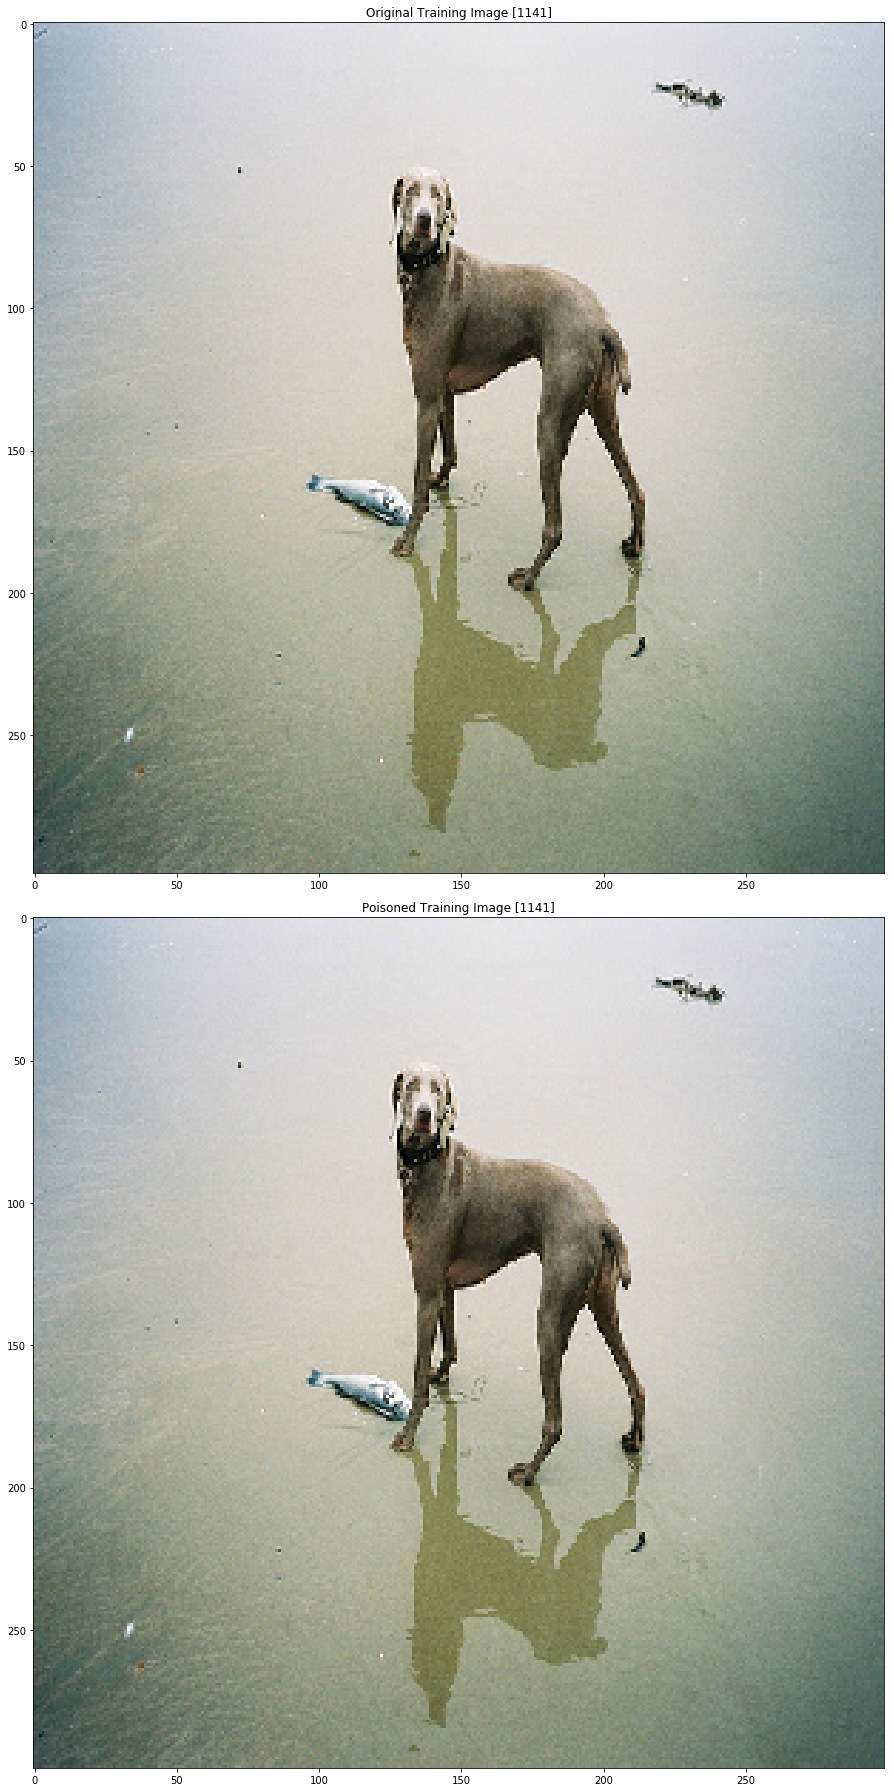

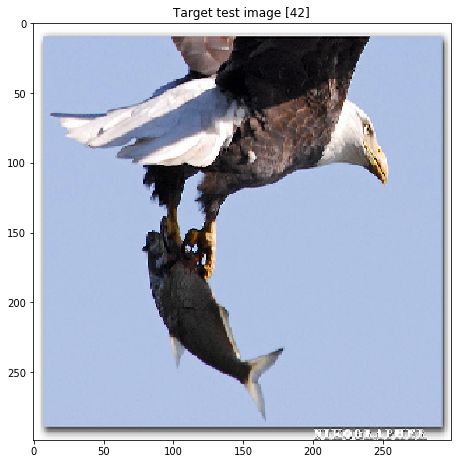

Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz


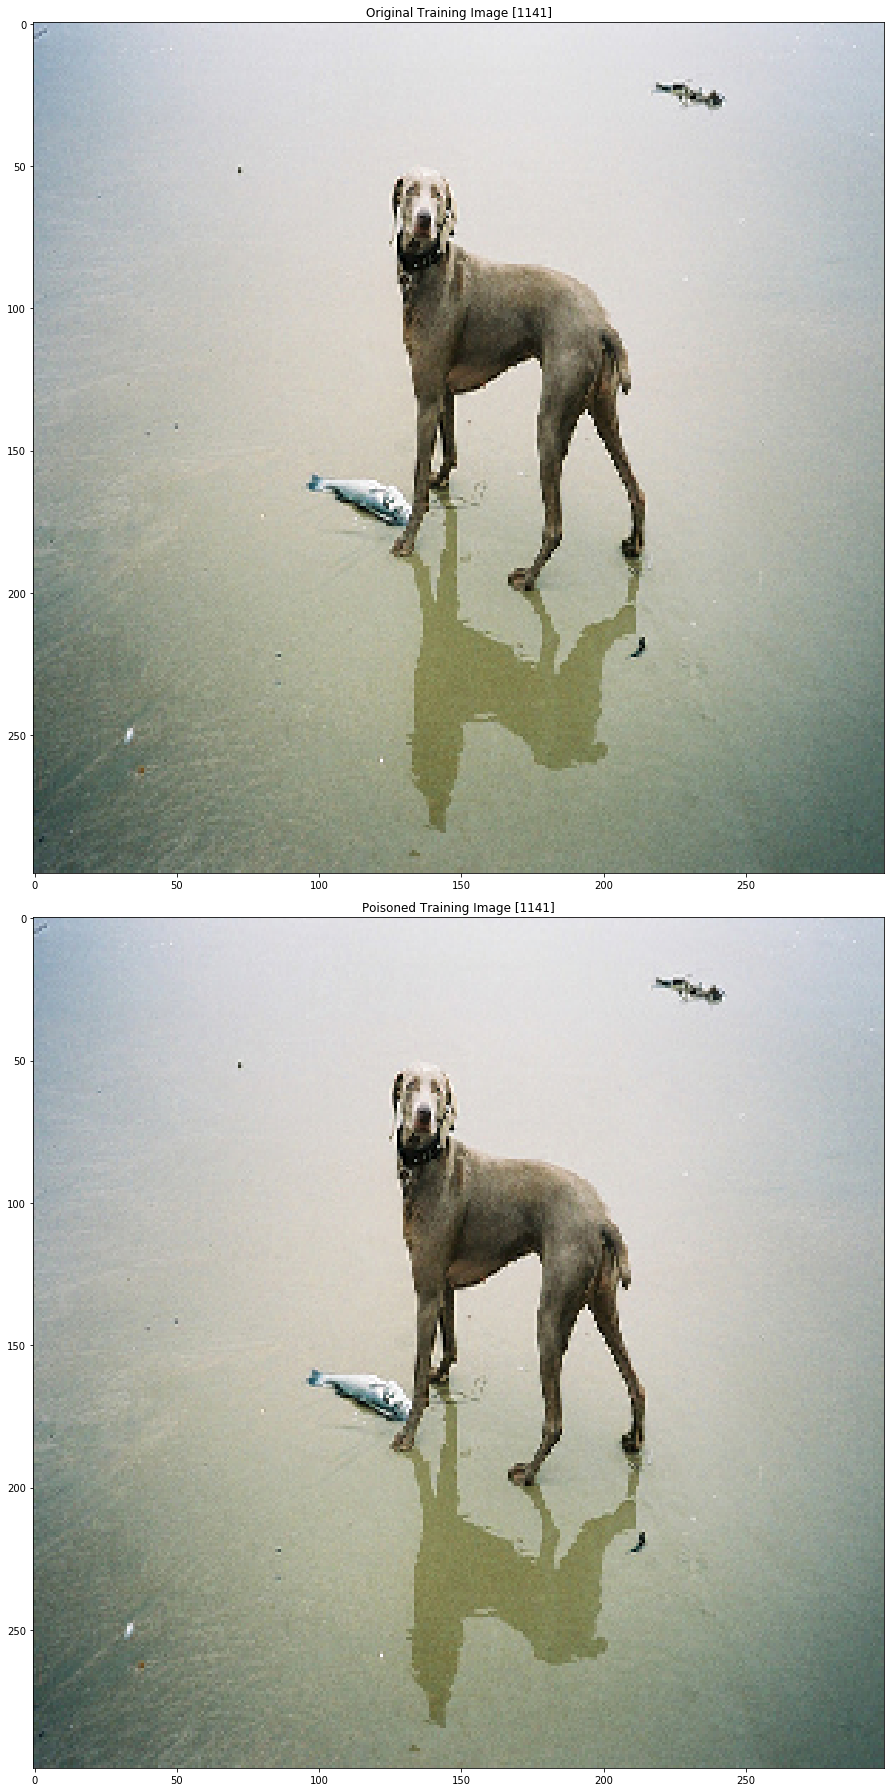

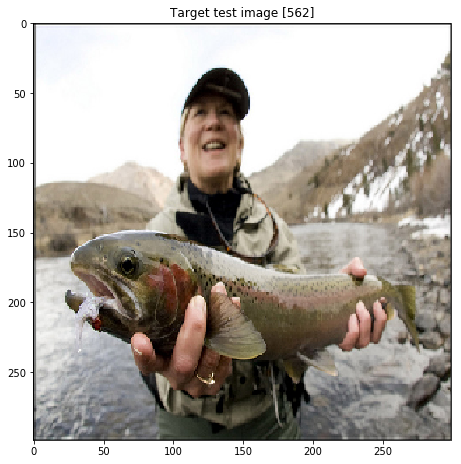

Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz


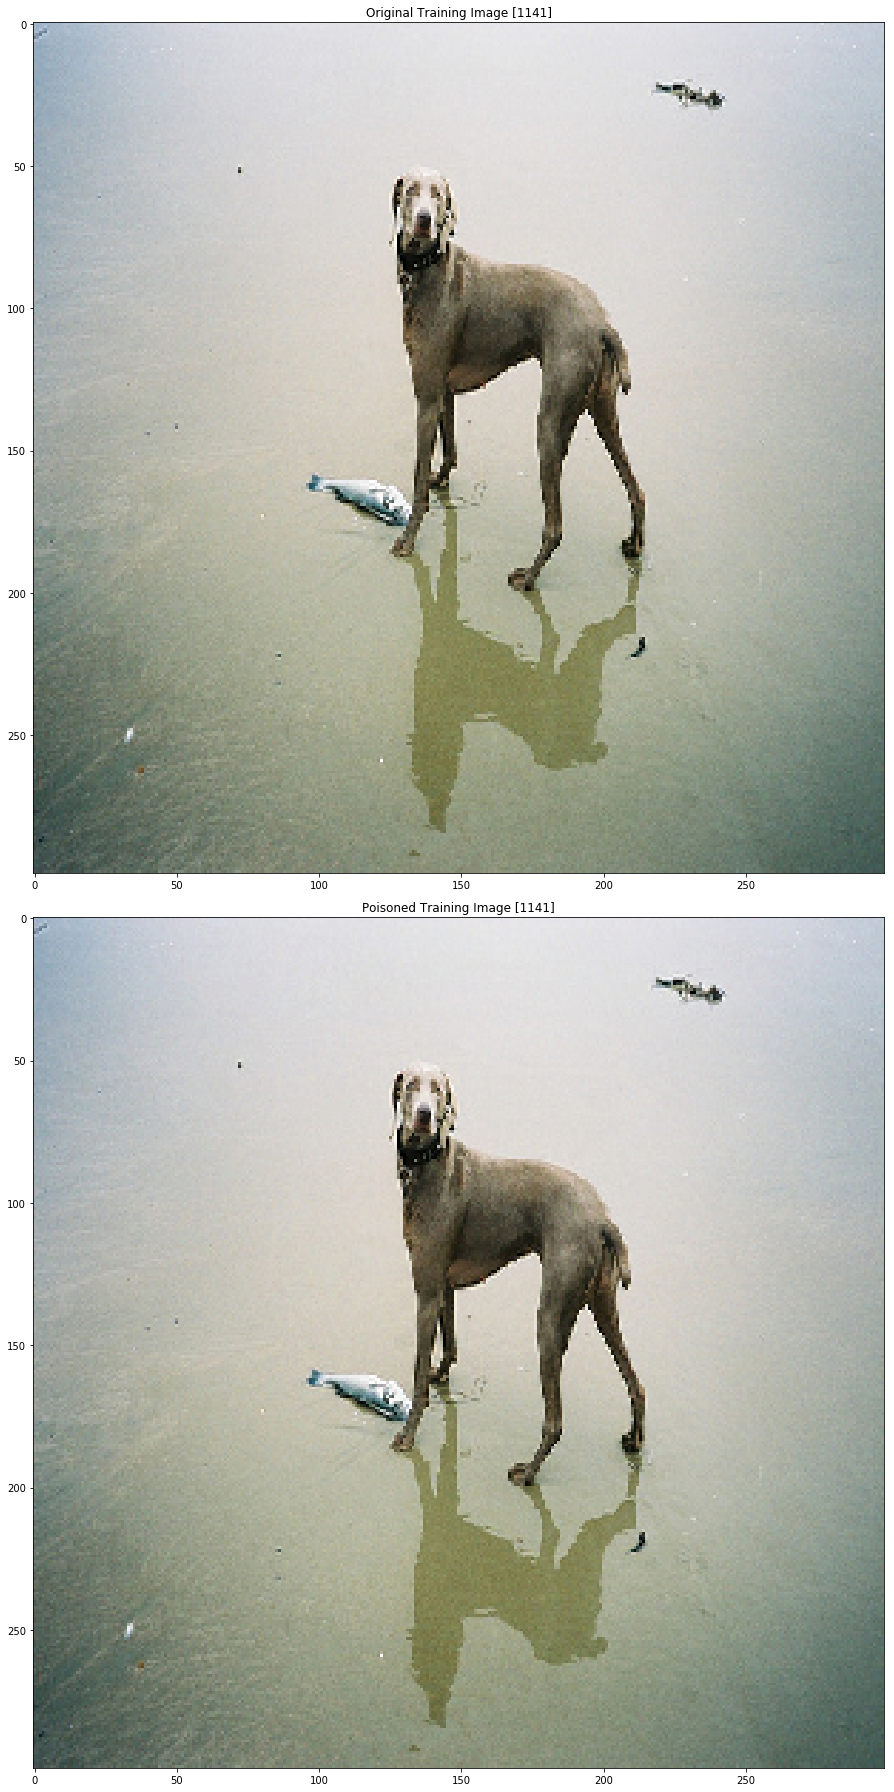

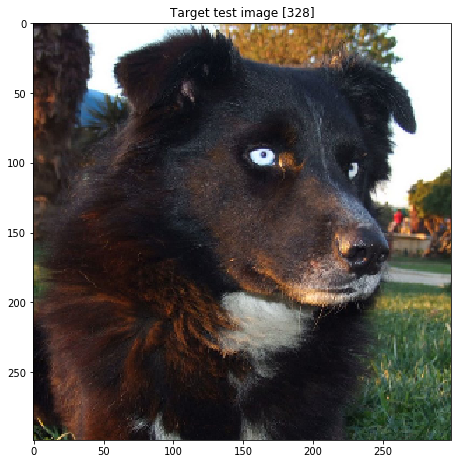

Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz


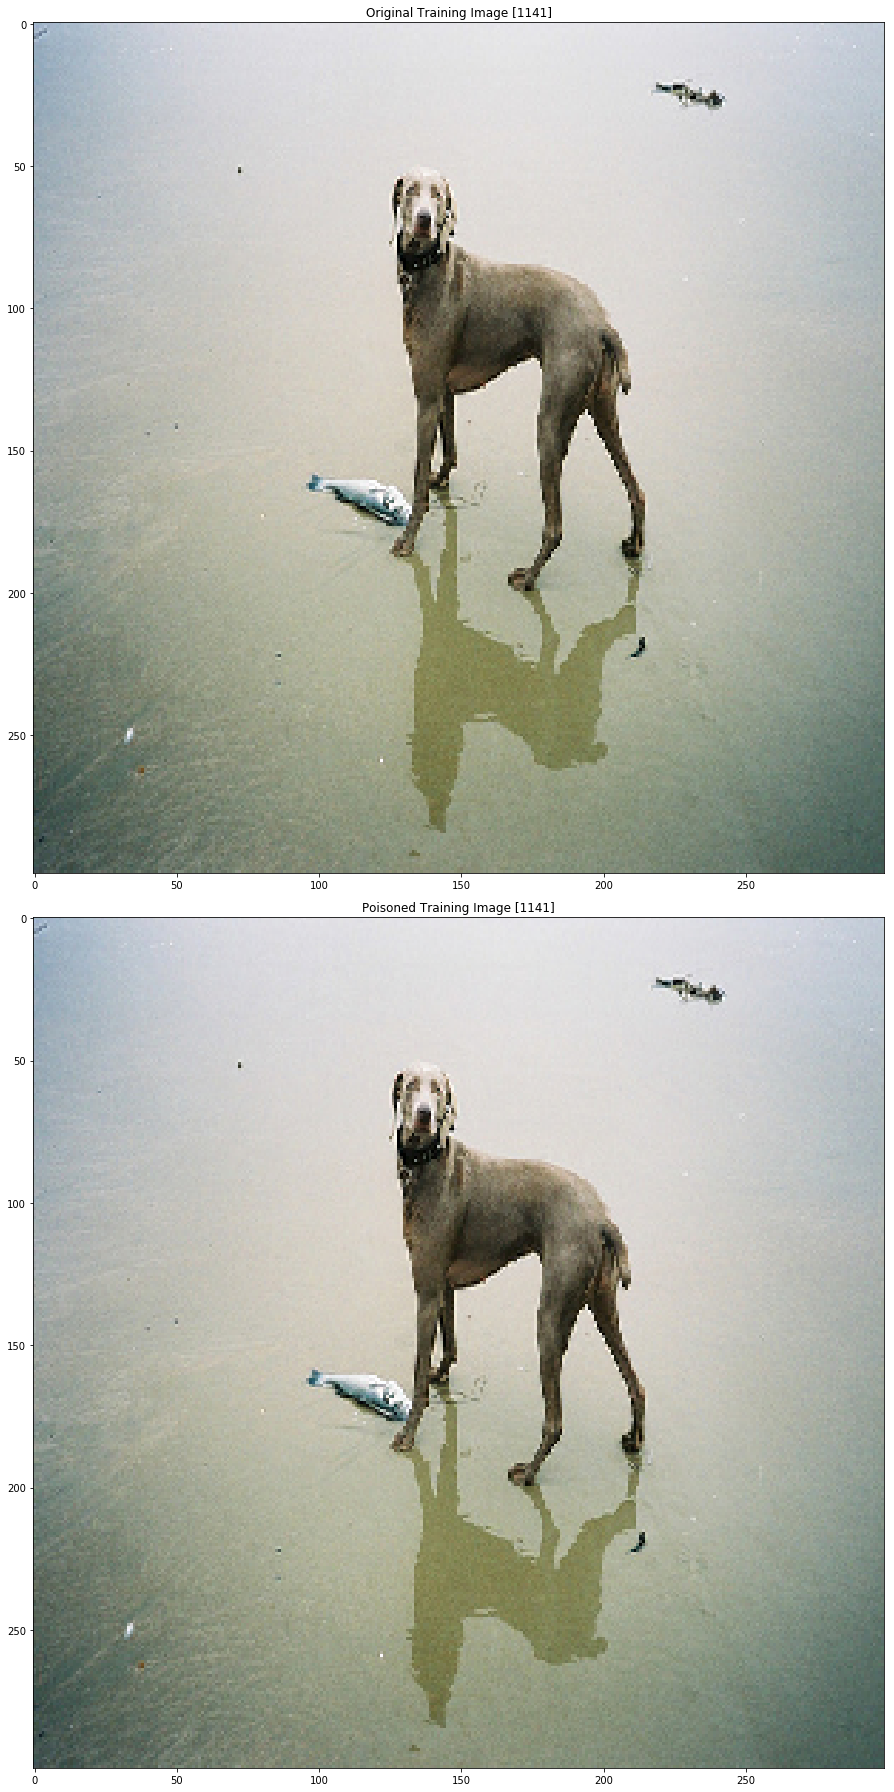

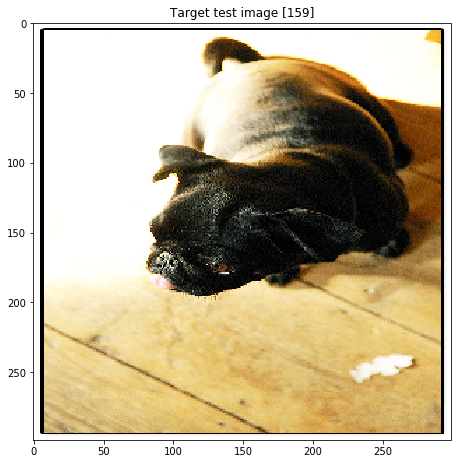

Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz


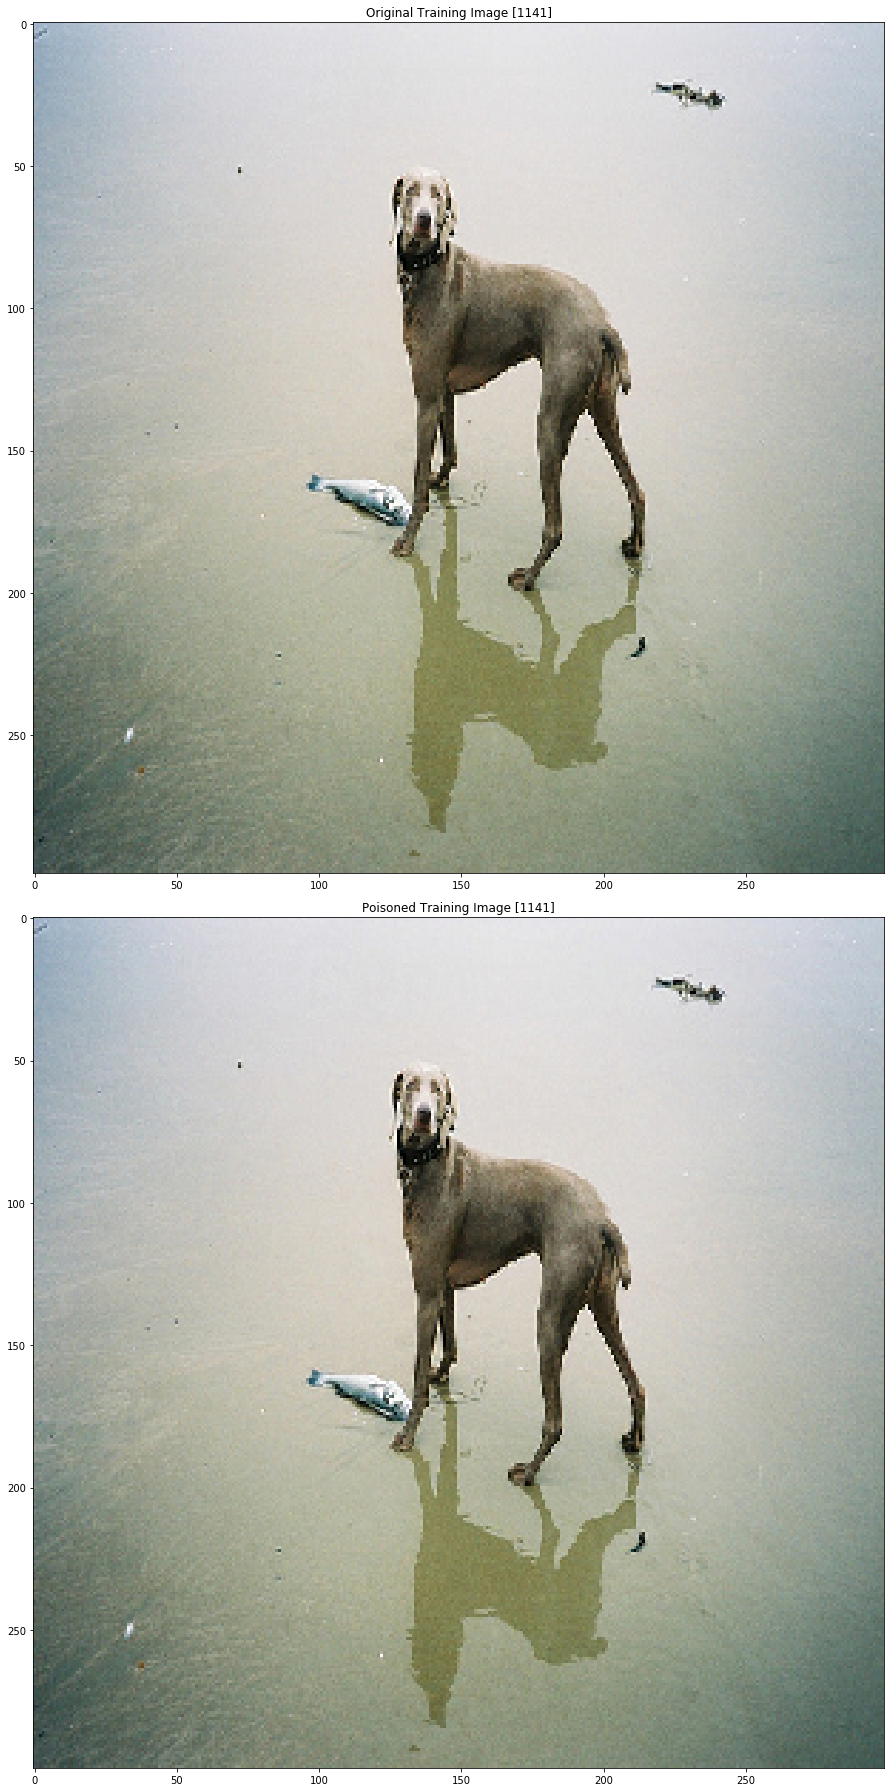

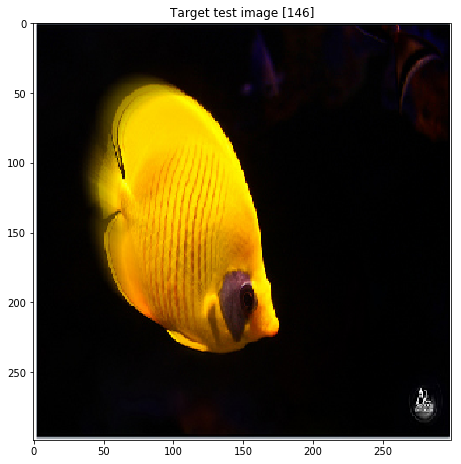

Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz


KeyboardInterrupt: 

In [18]:
for pair in indices_poisons_pairs:
    analyze_results(pair, visualize=True)

In [102]:
img_side = 299
num_channels = 3
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
weight_decay = 0.001

In [106]:
training_dataset_classes = ["dog", "fish"]
num_train_ex_per_class = 900
num_test_ex_per_class = 300
num_classes = len(training_dataset_classes)
num_training_points = num_train_ex_per_class * num_classes
num_testing_points = num_test_ex_per_class * num_classes
poisoned_training_points = []
poisoned_training_points_indices = [999]
target_test_points_indices = [15]
num_target_test_points = len(target_test_points_indices)
method = "IF" # or "FC"

In [107]:
def get_dataset(classes):
    classes_str = '_'.join(classes)
    dataset_name = '{}_{}_{}'.format(classes_str, num_train_ex_per_class, num_test_ex_per_class)
    # extract_and_rename_animals()
    data_sets = load_animals(num_train_ex_per_class=num_train_ex_per_class, 
                             num_test_ex_per_class=num_test_ex_per_class,
                             classes=classes)
    return data_sets

def render_img(img):
    img_copy = np.copy(img)
    img_copy /= 2
    img_copy += 0.5
    io.imshow(img_copy)

In [108]:
data_sets = get_dataset(training_dataset_classes)

Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz


In [109]:
full_graph = tf.Graph()
with full_graph.as_default():
    full_model_name = '%s_inception_wd-%s' % ('_'.join(training_dataset_classes), weight_decay)
    full_model = BinaryInceptionModel(
        img_side=img_side,
        num_channels=num_channels,
        weight_decay=weight_decay,
        num_classes=num_classes, 
        batch_size=batch_size,
        data_sets=data_sets,
        initial_learning_rate=initial_learning_rate,
        keep_probs=keep_probs,
        decay_epochs=decay_epochs,
        mini_batch=True,
        train_dir='output',
        log_dir='log',
        model_name=full_model_name)

self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:191 -   get_vec_to_list_fn() ] Total number of parameters: 2048


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
inception_features:  Tensor("flatten/Reshape:0", shape=(?, ?), dtype=float32)
x_poison_features:  Tensor("Gather:0", shape=(1, ?), dtype=float32)
t_target_features:  Tensor("Gather_1:0", shape=(1, ?), dtype=float32)
Lp:  Tensor("norm/Squeeze:0", shape=(), dtype=float32)
LP_gradient Tensor("strided_slice_1:0", shape=(268203,), dtype=float32)


## tSNE

array([-0.8862745 , -0.8433209 , -0.9215752 , ..., -0.42591977,
       -0.4119127 , -0.4980745 ], dtype=float32)

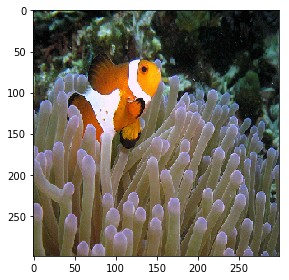

In [31]:
fn = get_projection_to_box_around_orig_point(data_sets.train.x[999], 0.5)
posioned_training_images_temp = fn(poisoned_training_points[0])
render_img(posioned_training_images_temp.reshape((img_side,img_side,num_channels)))
posioned_training_images_temp

((1800, 268203), (1, 268203), (1, 268203), (1, 268203))
Extracting latent space features...


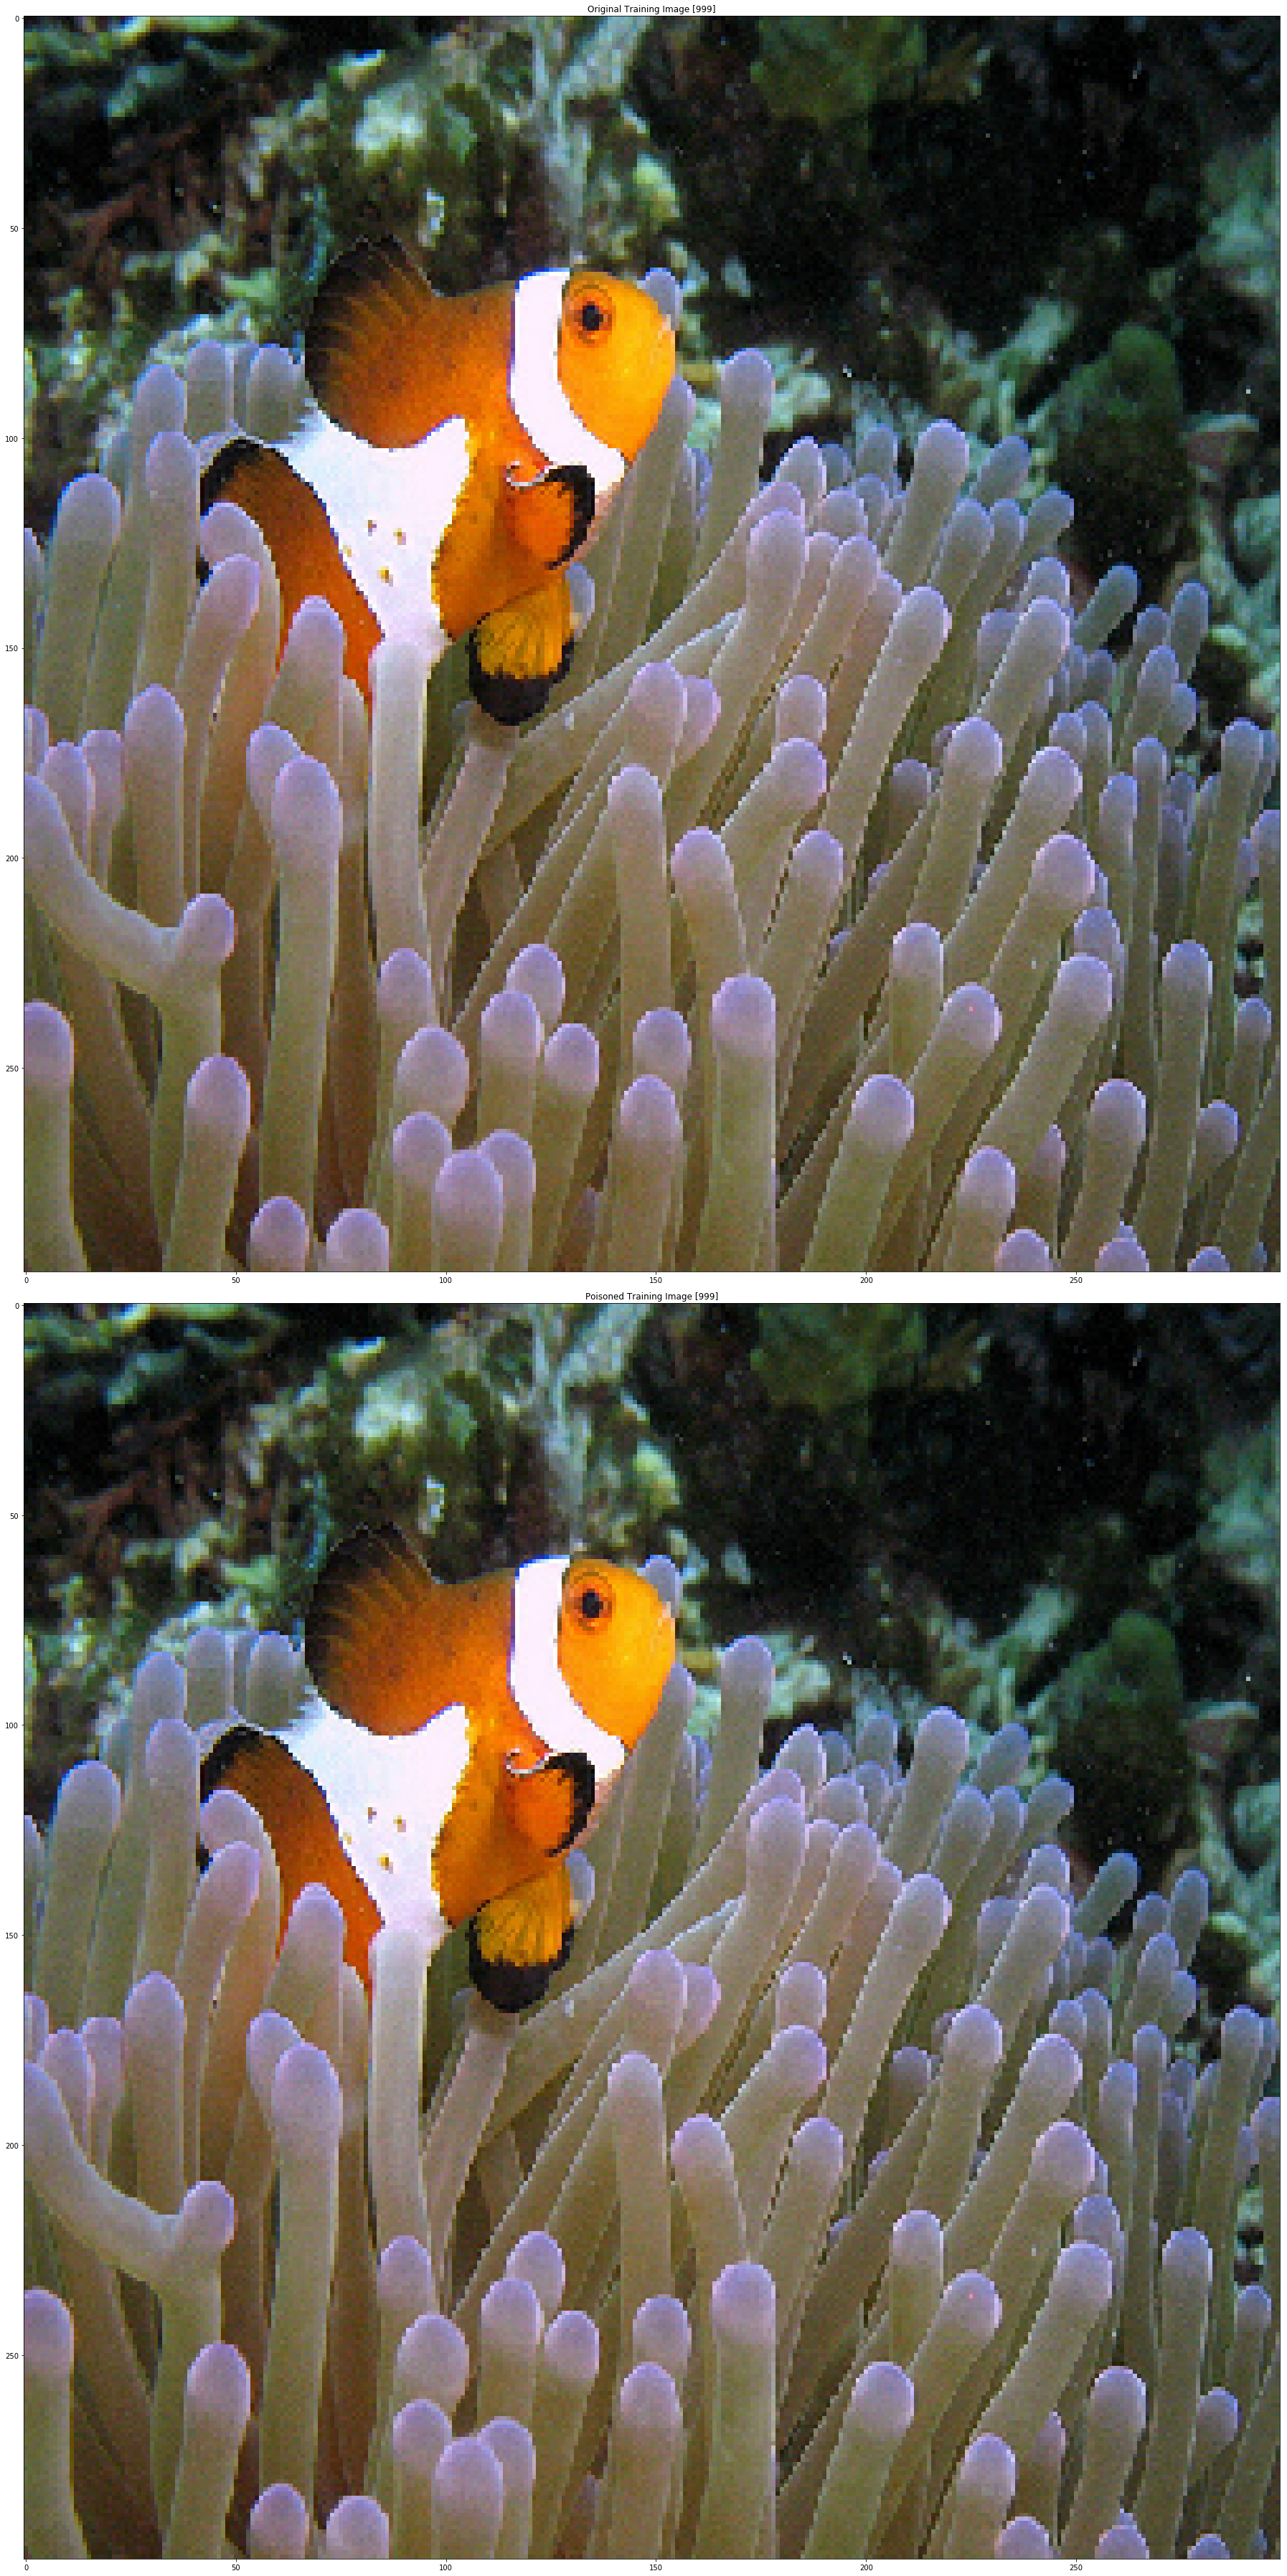

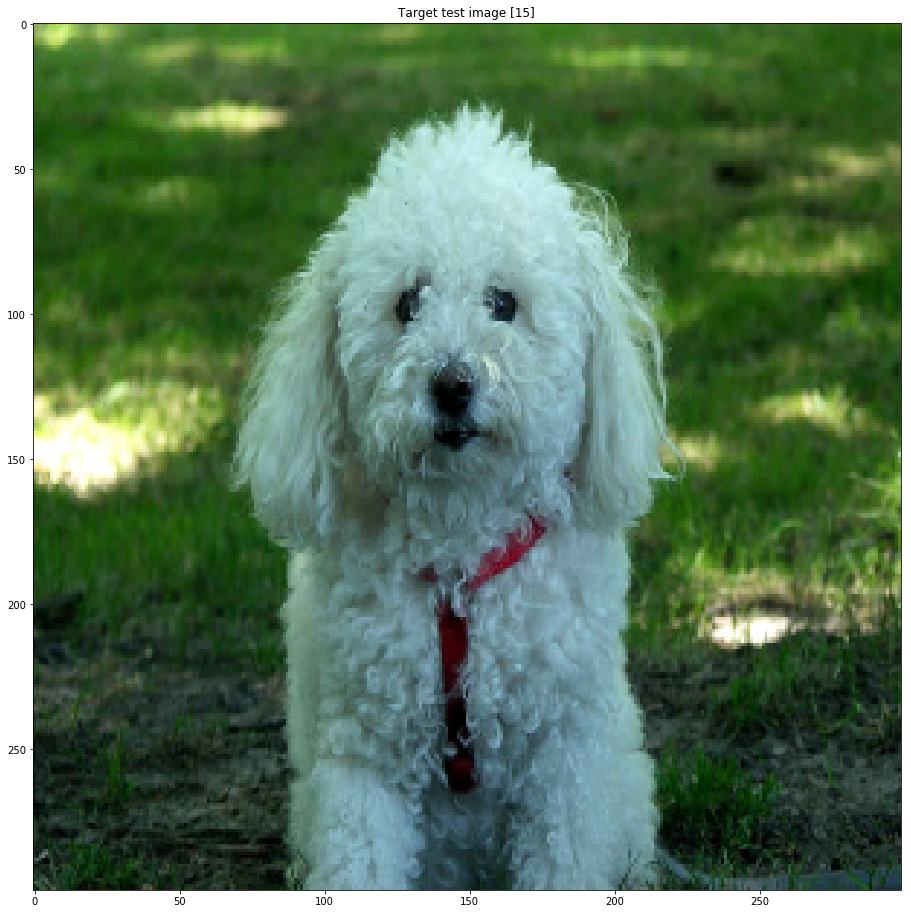

In [77]:
screen_width = 25.

# render relevant images

# clip poisoned images NOT DONE
# if method == "FC":
#     poisoned_training_points_clipped = np.copy(poisoned_training_points).reshape(num_poisoned_training_points, -1)
#     if np.max(poisoned_training_points_clipped, axis=1) > 1 or np.min(poisoned_image) < -1:
#         temp = np.max(poisoned_image_render) - np.min(poisoned_image_render)
#         poisoned_image_render /= temp

poisoned_training_points_clipped = np.asarray([posioned_training_images_temp])

if method == "IF":
    poisoned_training_points_to_render = poisoned_training_points
else:
    poisoned_training_points_to_render = poisoned_training_points_clipped
    
# render original training points and poisoned ones
plt.figure(figsize=(screen_width, screen_width/num_poisoned_training_points * 2))
for i, index_to_poison in enumerate(poisoned_training_points_indices):
    plt.subplot(2,num_poisoned_training_points,i+1)
    plt.title("Original Training Image [{}]".format(index_to_poison))
    render_img(data_sets.train.x[index_to_poison].reshape((img_side,img_side,num_channels)))

for i, (training_point, index_to_poison) in enumerate(zip(poisoned_training_points_to_render, poisoned_training_points_indices)):
    plt.subplot(2,num_poisoned_training_points,num_poisoned_training_points+i+1)
    plt.title("Poisoned Training Image [{}]".format(index_to_poison))
    render_img(training_point.reshape((img_side,img_side,num_channels)))

# render target test images
plt.figure(figsize=(screen_width,screen_width/num_target_test_points))
for target_index in target_test_points_indices:
    plt.subplot(2,num_poisoned_training_points,i+1)
    plt.title("Target test image [{}]".format(target_index))
    render_img(data_sets.test.x[target_index].reshape((img_side,img_side,num_channels)))
    
# Get tSNE plot

# Extract Inception features
all_dataset_x = np.concatenate([np.copy(data_sets.train.x), 
                                poisoned_training_points, 
                                poisoned_training_points_clipped if method == "FC" else [], 
                                data_sets.test.x[target_test_points_indices]
                               ], axis = 0)
all_dataset_labels = np.concatenate([np.copy(data_sets.train.labels),  
                                     np.copy(data_sets.train.labels[poisoned_training_points_indices]), 
                                     np.copy(data_sets.train.labels[poisoned_training_points_indices]) if method == "FC" else [],
                                     data_sets.test.labels[target_test_points_indices]], axis = 0)
all_dataset = DataSet(all_dataset_x, all_dataset_labels)
print "Extracting latent space features..."
with full_graph.as_default():
    all_inceptions = full_model.generate_inception_features(all_dataset, None)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1803 samples in 0.102s...
[t-SNE] Computed neighbors for 1803 samples in 11.255s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1803
[t-SNE] Computed conditional probabilities for sample 1803 / 1803
[t-SNE] Mean sigma: 3.947429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.917076
[t-SNE] Error after 300 iterations: 1.750677


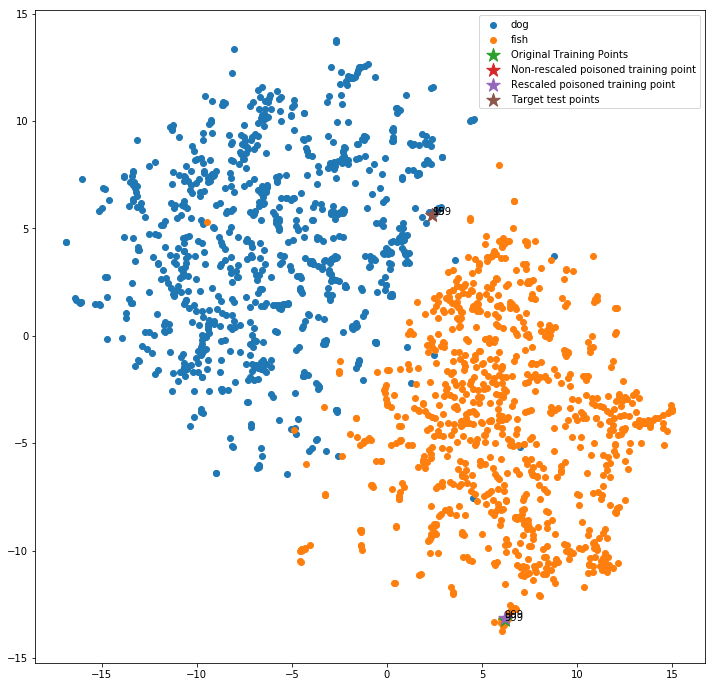

In [78]:
# Calculate tSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=69)
tsne_results = tsne.fit_transform(all_inceptions)

plt.figure(figsize=(12,12))
# plot entire training dataset
for class_label in range(num_classes):
    class_mask = data_sets.train.labels == class_label
    plt.scatter(tsne_results.T[0][:num_training_points][class_mask], 
                tsne_results.T[1][:num_training_points][class_mask], 
                label=training_dataset_classes[class_label]) 

# plot training points before poison
plt.scatter(tsne_results.T[0][poisoned_training_points_indices], 
            tsne_results.T[1][poisoned_training_points_indices], 
            label="Original Training Points", marker='*', s=200)
for index, coordinate in zip(poisoned_training_points_indices, tsne_results[poisoned_training_points_indices]):
    plt.annotate(s=str(index), xy = coordinate)
# plot training points after poison no clipping
plt.scatter(tsne_results.T[0][num_training_points:num_training_points+num_poisoned_training_points], 
            tsne_results.T[1][num_training_points:num_training_points+num_poisoned_training_points], 
            label="Non-rescaled poisoned training point", marker='*', s=200)
for index, coordinate in zip(poisoned_training_points_indices, tsne_results[num_training_points:num_training_points+num_poisoned_training_points]):
    plt.annotate(s=str(index), xy = coordinate)
# plot training points after poison with clipping (if applicable)
if method == "FC":
    plt.scatter(tsne_results.T[0][-num_target_test_points-num_poisoned_training_points:-num_target_test_points], 
                tsne_results.T[1][-num_target_test_points-num_poisoned_training_points:-num_target_test_points], 
                label="Rescaled poisoned training point", marker='*', s=200)
    for index, coordinate in zip(poisoned_training_points_indices, tsne_results[-num_target_test_points-num_poisoned_training_points:-num_target_test_points]):
        plt.annotate(s=str(index), xy = coordinate)
# plot target test points
plt.scatter( tsne_results.T[0][-num_target_test_points:], tsne_results.T[1][-num_target_test_points:], label="Target test points", marker='*', s=200)
for index, coordinate in zip(target_test_points_indices, tsne_results[-num_target_test_points:]):
    plt.annotate(s=str(index), xy = coordinate)

plt.legend()

## Before/after poison comparison

In [82]:
with full_graph.as_default():
    clean_w = full_model.retrain_and_get_weights(data_sets.train.x, data_sets.train.labels)

clean_total_test_logits = full_model.get_preds(data_sets.test, np.arange(len(data_sets.test.x)))
clean_total_test_acc = np.sum(np.argmax(clean_total_test_logits, axis=1) == data_sets.test.labels) / float(num_testing_points)
clean_test_logits = full_model.get_preds(data_sets.test, target_test_points_indices) # target_test_img_indices should be a list

In [90]:
poisoned_data_set_x = np.copy(data_sets.train.x)
poisoned_data_set_x[imgs_to_poison] = poisoned_images
poisoned_data_set_labels = np.copy(data_sets.train.labels)

with full_graph.as_default():
    poisoned_w = full_model.retrain_and_get_weights(poisoned_data_set_x, poisoned_data_set_labels)

poisoned_total_test_logits = full_model.get_preds(data_sets.test, np.arange(len(data_sets.test.x)))
poisoned_total_test_acc = np.sum(np.argmax(poisoned_total_test_logits, axis=1) == data_sets.test.labels) / float(num_testing_points)
poisoned_test_logits = full_model.get_preds(data_sets.test, target_test_points_indices) # target_test_img_indices should be a list

[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.01365254]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00461816]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.04596299]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [0.98]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.0037951695
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 4.2507358


In [91]:
poisoned_test_logits

array([[0.49942693, 0.5005731 ]], dtype=float32)

In [119]:
source_dir = "Experiment_results/Experiment_1/"

In [130]:
def parse_file_name(fn):
    fn = fn[:-4]
    fn = fn.split('/')[-1] # get rid of path leading up to file
    lst = fn.split('_')
    test_idx = int(lst[-1])
    num_poisoned_training_points = int(lst[-3])
    Experiment_number = int(lst[1])
    contents_type = lst[2]
    method = lst[3]
    dataset_name = lst[4]
    return {
        "test_idx":test_idx,
        "num_poisoned_training_points":num_poisoned_training_points,
        "Experiment_number":Experiment_number,
        "contents_type":contents_type,
        "method":method,
        "dataset_name":dataset_name
    }

In [131]:
parse_file_name(source_dir+indices_name)

{'Experiment_number': 1,
 'classes': ['Dog', 'Fish'],
 'contents_type': 'indices',
 'method': 'IF',
 'num_poisoned_training_points': 1,
 'test_idx': 146}

In [135]:
file_names = !ls -tr Experiment_results/Experiment_1/
file_names

['Experiment_1_indices_IF_Dog_Fish_num_train_1__568.npy',
 'Experiment_1_poisons_IF_Dog_Fish_num_train_1__568.npy',
 'Experiment_1_indices_IF_Dog_Fish_num_train_1__42.npy',
 'Experiment_1_poisons_IF_Dog_Fish_num_train_1__42.npy',
 'Experiment_1_poisons_IF_Dog_Fish_num_train_1__562.npy',
 'Experiment_1_indices_IF_Dog_Fish_num_train_1__562.npy',
 'Experiment_1_indices_IF_Dog_Fish_num_train_1__328.npy',
 'Experiment_1_poisons_IF_Dog_Fish_num_train_1__328.npy',
 'Experiment_1_indices_IF_Dog_Fish_num_train_1__159.npy',
 'Experiment_1_poisons_IF_Dog_Fish_num_train_1__159.npy',
 'Experiment_1_indices_IF_Dog_Fish_num_train_1__146.npy',
 'Experiment_1_poisons_IF_Dog_Fish_num_train_1__146.npy',
 'Experiment_1_indices_IF_Dog_Fish_num_train_1__71.npy',
 'Experiment_1_poisons_IF_Dog_Fish_num_train_1__71.npy',
 'Experiment_1_indices_IF_Eagle_Mushroom_num_train_1__26.npy',
 'Experiment_1_poisons_IF_Eagle_Mushroom_num_train_1__26.npy',
 'Experiment_1_indices_IF_Eagle_Mushroom_num_train_1__86.npy',
 'E

In [ ]:
img_side = 299
num_channels = 3
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
weight_decay = 0.001

training_dataset_classes = ["dog", "fish"]
num_train_ex_per_class = 900
num_test_ex_per_class = 300
batch_size = 100
num_classes = len(training_dataset_classes)

def get_dataset(classes):
    classes_str = '_'.join(classes)
    dataset_name = '{}_{}_{}'.format(classes_str, num_train_ex_per_class, num_test_ex_per_class)
    # extract_and_rename_animals()
    data_sets = load_animals(num_train_ex_per_class=num_train_ex_per_class, 
                             num_test_ex_per_class=num_test_ex_per_class,
                             classes=classes)
    return data_sets
    
data_sets = get_dataset(training_dataset_classes)

full_graph = tf.Graph()
with full_graph.as_default():
    full_model_name = '%s_inception_wd-%s' % ('_'.join(training_dataset_classes), weight_decay)
    full_model = BinaryInceptionModel(
        img_side=img_side,
        num_channels=num_channels,
        weight_decay=weight_decay,
        num_classes=num_classes, 
        batch_size=batch_size,
        data_sets=data_sets,
        initial_learning_rate=initial_learning_rate,
        keep_probs=keep_probs,
        decay_epochs=decay_epochs,
        mini_batch=True,
        train_dir='output',
        log_dir='log',
        model_name=full_model_name)

results = []
for i in range(0,len(file_names),2):
    first_is_indices = parse_file_name(file_names[i])["contents_type"] == "indices"
    if first_is_indices:
        result = get_logits(file_names[i], file_names[i+1])
    else:
        result = get_logits(file_names[i+1], file_names[i])
    results.append(result)

In [136]:
def get_logits(indices_file_name, poison_file_name, data_sets, full_graph, full_model):
    indices_metadata = parse_file_name(indices_file_name)
    target_test_points_indices = [indices_metadata['test_idx']]
    num_testing_points = len(data_sets.test.labels)
    imgs_to_poison = np.load(indices_file_name)
    poisoned_images = np.load(poison_file_name)
    
    print "Training on clean dataset..."
    with full_graph.as_default():
        clean_w = full_model.retrain_and_get_weights(data_sets.train.x, data_sets.train.labels)

    clean_total_test_logits = full_model.get_preds(data_sets.test, np.arange(len(data_sets.test.x)))
    clean_total_test_acc = np.sum(np.argmax(clean_total_test_logits, axis=1) == data_sets.test.labels) / float(num_testing_points)
    clean_test_logits = full_model.get_preds(data_sets.test, target_test_points_indices) # target_test_img_indices should be a list
    
    poisoned_data_set_x = np.copy(data_sets.train.x)
    poisoned_data_set_x[imgs_to_poison] = poisoned_images
    poisoned_data_set_labels = np.copy(data_sets.train.labels)

    print "Training on poisoned dataset..."
    with full_graph.as_default():
        poisoned_w = full_model.retrain_and_get_weights(poisoned_data_set_x, poisoned_data_set_labels)

    poisoned_total_test_logits = full_model.get_preds(data_sets.test, np.arange(len(data_sets.test.x)))
    poisoned_total_test_acc = np.sum(np.argmax(poisoned_total_test_logits, axis=1) == data_sets.test.labels) / float(num_testing_points)
    poisoned_test_logits = full_model.get_preds(data_sets.test, target_test_points_indices) # target_test_img_indices should be a list
    
    return (clean_total_test_acc, poisoned_total_test_acc), (clean_test_logits, poisoned_test_logits)

In [137]:
indices_name = "Experiment_1_indices_IF_Dog_Fish_num_train_1__146.npy"
poison_name = "Experiment_1_poisons_IF_Dog_Fish_num_train_1__146.npy"
get_logits(source_dir+indices_name, source_dir+poison_name, data_sets, full_graph, full_model)

Training on clean dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.01212904]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00397613]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.04845406]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [0.985]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 1.7022793e-06
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 4.038047


Training on poisoned dataset...


[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.01408689]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00466888]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.04886136]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [0.98166667]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.0066391197
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 4.3400483


((0.985, 0.9816666666666667),
 (array([[6.2501538e-05, 9.9993753e-01]], dtype=float32),
  array([[0.00884033, 0.99115974]], dtype=float32)))